# Ensemble Methods: Decision Trees, Random Forests, Gradient Boosted Trees, XG Boost & Calibration
# By Emma Corbett
# Fall 2024

The following dataset is a Bank Marketing dataset, containing information about direct marketing campaigns (phone calls) of a banking institution. The goal is to predict whether the client will subscribe to a term deposit (target variable: 'deposit' is yes/no). 

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier 
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

## Decision Trees

In [2]:

bank_df = pd.read_csv('bank.csv')
print(bank_df)
print(bank_df.dtypes)

       age          job  marital  education default  balance housing loan  \
0       59       admin.  married  secondary      no     2343     yes   no   
1       56       admin.  married  secondary      no       45      no   no   
2       41   technician  married  secondary      no     1270     yes   no   
3       55     services  married  secondary      no     2476     yes   no   
4       54       admin.  married   tertiary      no      184      no   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
11157   33  blue-collar   single    primary      no        1     yes   no   
11158   39     services  married  secondary      no      733      no   no   
11159   32   technician   single  secondary      no       29      no   no   
11160   43   technician  married  secondary      no        0      no  yes   
11161   34   technician  married  secondary      no        0      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \

In [3]:
# check for missing values
missing_values = bank_df.isnull().sum()
print(missing_values) # there are no null values


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


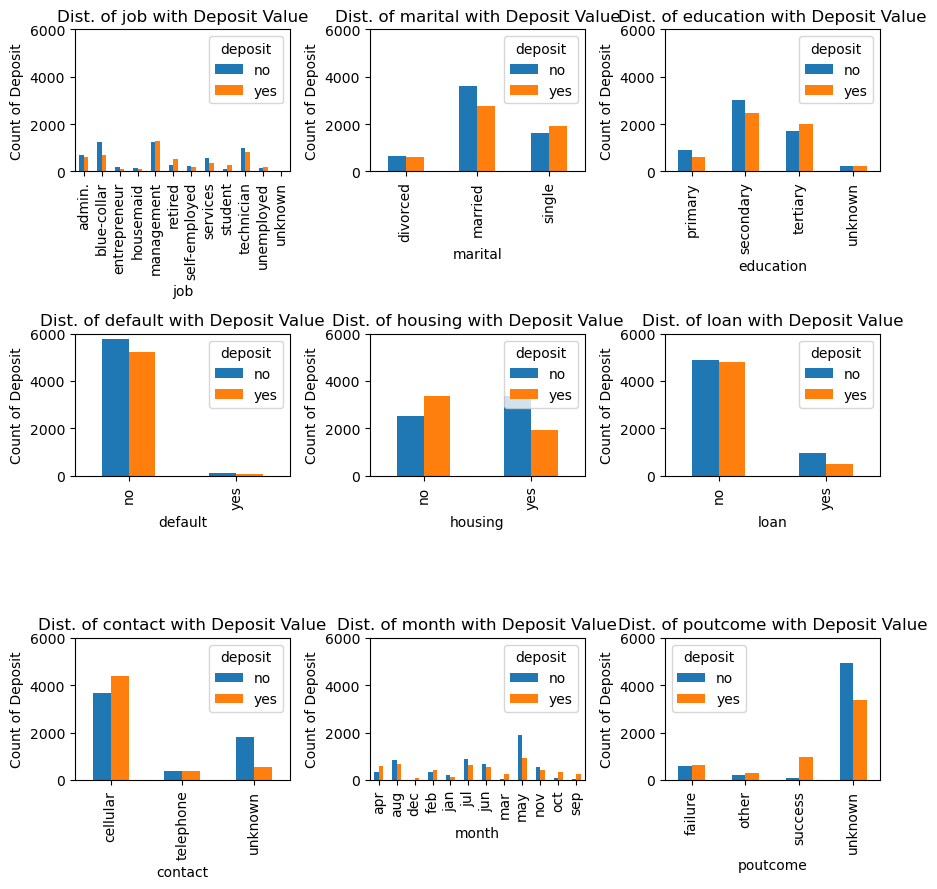

In [4]:
## Look at distribution of cat variables
categorical_vars = ['job', 'marital','education','default','housing','loan','contact', 'month','poutcome']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    cat_data = bank_df.groupby([var, 'deposit']).size().unstack(fill_value=0)
    cat_data.plot(kind='bar', stacked=False, ax=axes[i])
    # Set the y axis to be the same for easier comparison across categorical vars 
    axes[i].set_ylim(0, 6000)
    axes[i].set_title(f'Dist. of {var} with Deposit Value')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count of Deposit')

plt.tight_layout()
plt.show()


In [5]:
# split data using stratified to ensure consisten proportions of target var
bank_y = bank_df['deposit']
bank_X = bank_df.drop(columns=['deposit'])

X_train, X_test, y_train, y_test = train_test_split(bank_X, bank_y, test_size = 0.2, stratify=bank_y)


In [6]:
## Dropping poutcome since a lot of unknown vals
X_train = X_train.drop(columns=['poutcome'])
X_test = X_test.drop(columns=['poutcome'])
 
ohe = ['marital','education','default','housing','loan','contact','job']

X_train = pd.get_dummies(X_train, columns=ohe, dtype='int', drop_first=True)
o_encoder = OrdinalEncoder()
X_train['month'] = o_encoder.fit_transform(X_train[['month']])

X_test = pd.get_dummies(X_test, columns=ohe, dtype='int', drop_first=True)
o_encoder = OrdinalEncoder()
X_test['month'] = o_encoder.fit_transform(X_test[['month']])


In [7]:
# fitting decision tree until leaves are pure
decision_tree = DecisionTreeClassifier(criterion='entropy',
                                       max_depth=None)

decision_tree.fit(X_train, y_train)

y_pred_train = decision_tree.predict(X_train)
print("Accuracy on test data:", accuracy_score(y_train, y_pred_train))
y_pred_test = decision_tree.predict(X_test)
print("Accuracy on test data:", accuracy_score(y_test, y_pred_test))

Accuracy on test data: 1.0
Accuracy on test data: 0.7711598746081505


**Visualize the tree**

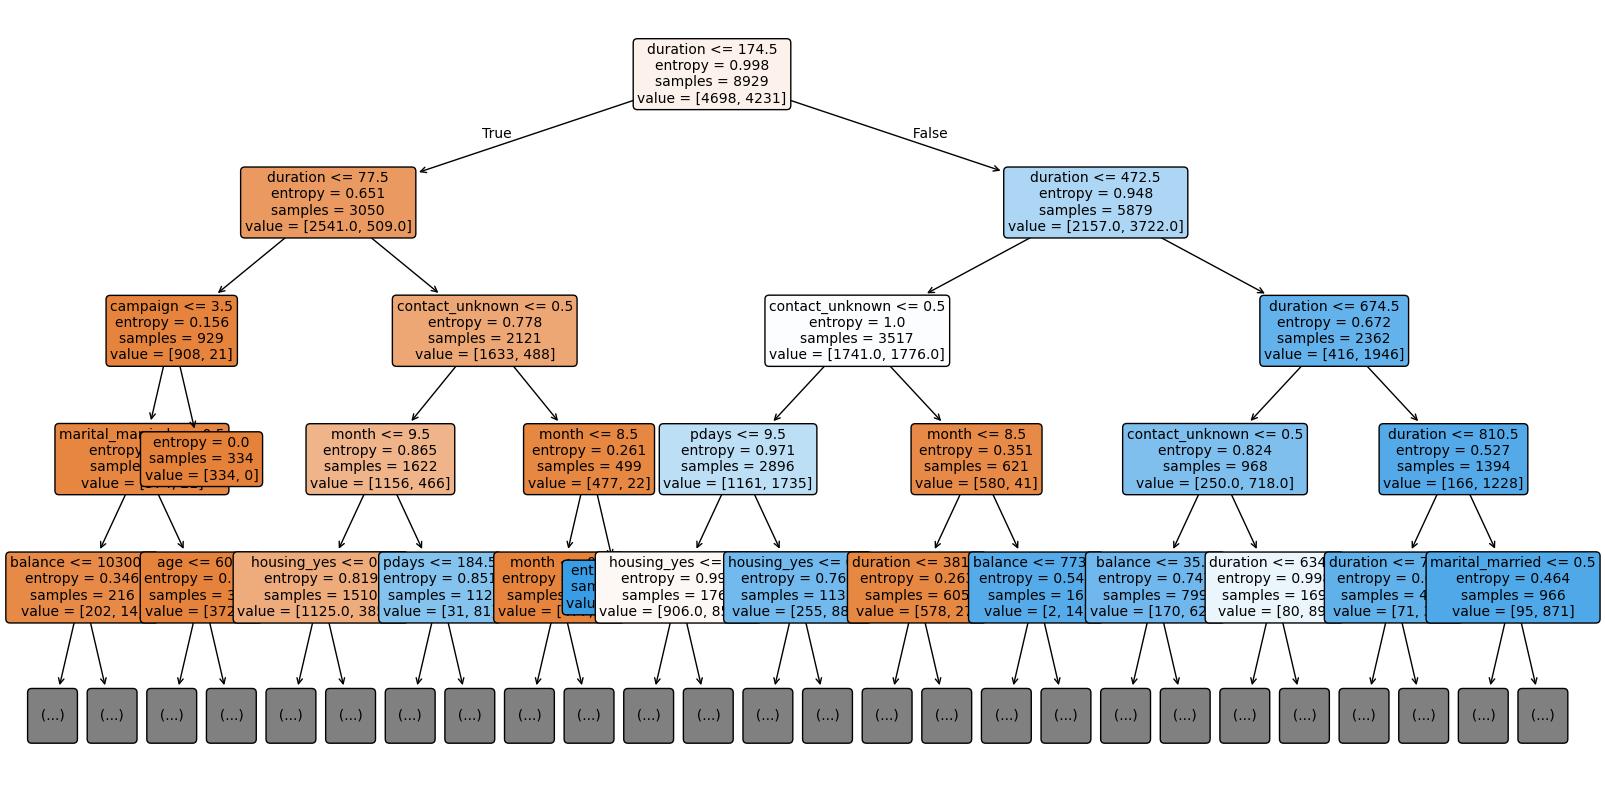

In [8]:

plt.figure(figsize=(20, 10))
plot_tree(decision_tree, 
          feature_names=X_train.columns.values.tolist(), 
          filled=True, 
          rounded=True, 
          max_depth=4,
          fontsize=10)
plt.show()

In [9]:
# test pruning the tree
path = decision_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# do not want to prune the entire tree
ccp_alphas = ccp_alphas[:-1]
impurities = impurities[:-1]

trees = []
performance = []

for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    pruned_tree.fit(X_train, y_train)
    trees.append(pruned_tree)
    
    y_pred = pruned_tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    performance.append(acc)

optimal_index = np.argmax(performance)
optimal_ccp_alpha = ccp_alphas[optimal_index]
optimal_accuracy = performance[optimal_index]

print("Optimal value of ccp alpha: ", optimal_ccp_alpha, " with accuracy: ", optimal_accuracy)

Optimal value of ccp alpha:  0.0003359838727741068  with accuracy:  0.8172861621137483


In [10]:

optimal_trained_tree = trees[optimal_index]
feature_importances = optimal_trained_tree.feature_importances_
top_3_indices = np.argsort(feature_importances)[-3:][::-1]
top_features = X_train.columns.values[top_3_indices]
print("The top features are: ", top_features) 

The top features are:  ['duration' 'month' 'contact_unknown']


## Random Forests

In [11]:
# train random forest to compare to decision tree
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
num_y_test = [1 if x == 'yes' else 0 for x in y_test]
num_y_pred = [1 if x == 'yes' else 0 for x in y_pred]
print("F1 score on test data:", f1_score(num_y_test, num_y_pred))

Accuracy on test data: 0.8235557545902373
F1 score on test data: 0.8202554744525548


In [12]:
# verify if leaves are pure

isPure = True
for tree in rfc.estimators_:
    leaves = tree.apply(X_train)
    for leaf in set(leaves):
        if len(set(y_train[leaves == leaf])) > 1:
            isPure = False
            break
print("All trees have pure leaves? : ", isPure)
# All trees do not have pure leaves

score = rfc.score(X_test, y_test)
print("Score: ", score)

All trees have pure leaves? :  False
Score:  0.8235557545902373


In [13]:
# Hyperparameter tuning
n_estimators = [100, 200, 300, 400, 500]
max_depths = [None, 5, 10, 20, 30]
scores = {}
trees = {}
for n_estimator in n_estimators:
    for max_depth in max_depths:
        rand_forest = RandomForestClassifier(oob_score=True,
                                            random_state=100,
                                            warm_start=True,
                                            n_estimators=n_estimator,
                                            max_depth=max_depth)
        rand_forest.fit(X_train, y_train)
        oob_score = rand_forest.oob_score_
        scores[(n_estimator, max_depth)] = oob_score
        trees[(n_estimator, max_depth)] = rand_forest
        
optimal_hp = max(scores, key=scores.get)
score = scores[optimal_hp]

print("Optimal number of trees: ", optimal_hp[0])
print("Optimal max depth of trees: ", optimal_hp[1])
print("Score of best random forest with these parameters: ", score)

optimal_tree = trees[optimal_hp]
y_pred_train = optimal_tree.predict(X_train)
y_pred_test = optimal_tree.predict(X_test)
print("Accuracy on train data:", accuracy_score(y_train, y_pred_train))
print("Accuracy on test data:", accuracy_score(y_test, y_pred_test))

# Yes performance has improved but only a little. 

Optimal number of trees:  500
Optimal max depth of trees:  20
Score of best random forest with these parameters:  0.846007391645201
Accuracy on train data: 0.9993280322544518
Accuracy on test data: 0.8298253470667264


In [14]:

feature_importances_forest = optimal_tree.feature_importances_
top_3_indices_forest = np.argsort(feature_importances_forest)[-3:][::-1]
top_features_forest = X_train.columns.values[top_3_indices_forest]
print("The top features are: ", top_features_forest)
 

The top features are:  ['duration' 'balance' 'age']


## Gradient Boosted Trees

In [15]:

hgbr = HistGradientBoostingClassifier(random_state=42)
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_leaf': [10, 20, 30],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(hgbr, parameters, cv=5, scoring='accuracy', n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

total_time = end_time - start_time
optimal_booster = grid_search.best_estimator_
y_pred = optimal_booster.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Time taken to do model selection: ", total_time)
print("Optimal hyperparameters: ", grid_search.best_params_)
print("Test accuracy from optimal model: ", accuracy)

Time taken to do model selection:  12.660546064376831
Optimal hyperparameters:  {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 10}
Test accuracy from optimal model:  0.8414688759516346


## XGBoost

In [16]:
# XGBoost for comparison
xgboost = XGBClassifier(random_state=42)
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(xgboost, parameters, cv=5, scoring='accuracy', n_jobs=-1)
num_y_test = [1 if x == 'yes' else 0 for x in y_test]
num_y_train = [1 if x == 'yes' else 0 for x in y_train]
start_time = time.time()
grid_search.fit(X_train, num_y_train)
end_time = time.time()

total_time = end_time - start_time
optimal_booster_xg = grid_search.best_estimator_
y_pred = optimal_booster_xg.predict(X_test)
accuracy = accuracy_score(num_y_test, y_pred)

print("Time taken to do model selection: ", total_time)
print("Optimal hyperparameters: ", grid_search.best_params_)
print("Test accuracy from optimal model: ", accuracy)

Time taken to do model selection:  11.311253070831299
Optimal hyperparameters:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Test accuracy from optimal model:  0.8441558441558441


In [17]:

xgboost_features = optimal_booster_xg.get_booster().get_score(importance_type='gain')
xgboost_features_df = pd.DataFrame(list(xgboost_features.items()), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
top_3_xgb_features = xgboost_features_df.head(3)
print("Top 3 imortant features from trained XGBoost model: ", top_3_xgb_features)

Top 3 imortant features from trained XGBoost model:              feature  importance
17  contact_unknown   39.222145
4          duration   22.744699
14      housing_yes   19.222090


In [18]:
# top 5 xgboost features
top_5_xgb_features = xgboost_features_df.head(5)['feature']
all_features = feature_names=X_train.columns.values.tolist()
top_5_xgb_final_features = list(set(all_features) - set(top_5_xgb_features))

X_train_5 = X_train.drop(columns=top_5_xgb_final_features)
X_test_5 = X_test.drop(columns=top_5_xgb_final_features)

xgboost_top5 = XGBClassifier(random_state=42)
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(xgboost_top5, parameters, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train_5, num_y_train)
end_time = time.time()

total_time = end_time - start_time
optimal_booster = grid_search.best_estimator_
y_pred = optimal_booster.predict(X_test_5)
accuracy = accuracy_score(num_y_test, y_pred)

print("Time taken to do model selection: ", total_time)
print("Optimal hyperparameters: ", grid_search.best_params_)
print("Test accuracy from optimal model: ", accuracy)

Time taken to do model selection:  4.20881199836731
Optimal hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Test accuracy from optimal model:  0.8042991491267353


## Calibration

In [19]:
## Brier score
y_prob = optimal_booster_xg.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(num_y_test, y_prob)

brier_score

0.11751965386526235

Brier score after calibration: 0.12466087205821566


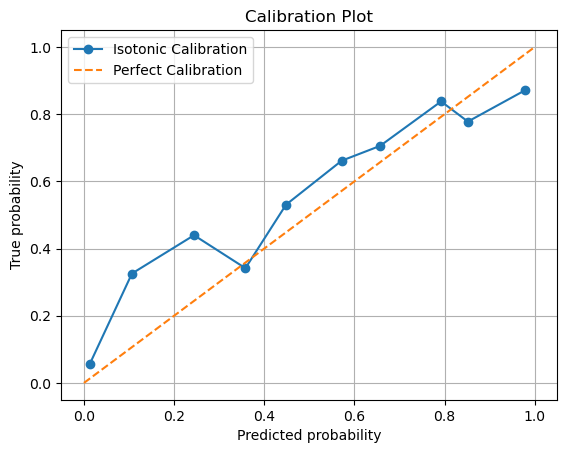

In [20]:
# isotonic regression 
calibrated_xg = CalibratedClassifierCV(estimator=optimal_booster_xg, method='isotonic', cv='prefit')
calibrated_xg.fit(X_train, num_y_train)

y_pred_proba_calibrated = calibrated_xg.predict_proba(X_test)[:, 1]

brier_score_calibrated = brier_score_loss(num_y_test, y_pred_proba_calibrated)
print("Brier score after calibration:", brier_score_calibrated)

# predicted vs actual
prob_true, prob_pred = calibration_curve(num_y_test, y_pred_proba_calibrated, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Isotonic Calibration")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")

plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Plot")
plt.legend()
plt.grid(True)
plt.show()
